In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import t, norm, rankdata
import warnings
warnings.filterwarnings('ignore')

# Enter 2 columns of B (before), A (after)
A = {'Total': [16.6,33.3,34.1,0,119.8,.1,25.3,359.3,6.6,.4,62.8,.2,13,0,0,5.9,.1,6,32.1,0]}
B = {'Total': [289.4,0,620.4,0,8.5,5.5,43.2,91.7,200.9,113.8,102.2,108.2,36.9,122,101.9]}

d1 = pd.DataFrame(A, columns=['Total'])
d1['Sample'] = 'S'
d2 = pd.DataFrame(B, columns=['Total'])
d2['Sample'] = 'N'
df = pd.concat([d1, d2])
df = df.sort_values(by='Total', axis=0).reset_index(drop=True)
df['Rank'] = rankdata(df['Total'])
df['N_Ranks'] = df.apply(lambda X: X['Rank'] if X.Sample=='N' else 0, axis=1)
df['#(Ni > Sj)'] = [sum(df['Rank'][df.Sample=='S'] < x) for x in df['N_Ranks'].values]
df

,Total,Sample,Rank,N_Ranks,#(Ni > Sj)
0,0.0,S,3.5,0.0,0
1,0.0,N,3.5,3.5,0
2,0.0,N,3.5,3.5,0
3,0.0,S,3.5,0.0,0
4,0.0,S,3.5,0.0,0
5,0.0,S,3.5,0.0,0
6,0.1,S,7.5,0.0,0
7,0.1,S,7.5,0.0,0
8,0.2,S,9.0,0.0,0
9,0.4,S,10.0,0.0,0


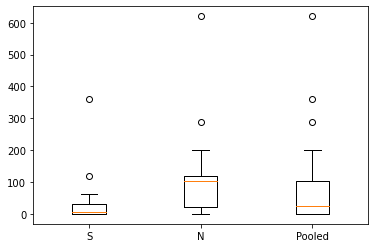

In [2]:
plt.boxplot([df['Total'][df.Sample=='S'], 
             df['Total'][df.Sample=='N'],
             df['Total']], 
             labels=['S', 'N', 'Pooled']);

In [3]:
# Compute the means and variances for 2 samples
mean_S = df['Total'][df.Sample=='S'].mean() 
var_S  = df['Total'][df.Sample=='S'].var()  
mean_N = df['Total'][df.Sample=='N'].mean()
var_N  = df['Total'][df.Sample=='N'].var()
med_S  = df['Total'][df.Sample=='S'].median()
med_N  = df['Total'][df.Sample=='N'].median() 
round(med_S, 3), round(mean_S, 3), round(var_S, 3),round(med_N, 3), round(mean_N, 3), round(var_N, 3)

(6.3, 35.78, 6646.819, 101.9, 122.973, 25305.864)

In [4]:
# Compute the pooled sample variance
n, m = len(df[df.Sample=='S']), len(df[df.Sample=='N'])
var_P = ((n - 1) * var_S + (m - 1) * var_N) / (n + m - 2)

# Compute the T statistics under H0
t_null = abs(mean_S - mean_N) / (var_P / n + var_P / m)**0.5
round(var_P, 3), round(t_null, 3)

(14562.777, 2.115)

In [5]:
# Compute the ddof for T statistics
ddof = (var_S / n + var_N / m)**2 / ((var_S / n)**2 / (n - 1) + (var_N / m)**2 / (m - 1))
round(ddof, 3)

19.502

In [6]:
# Compute the p_value
p_value = 2 * t.sf(t_null, round(ddof, 0))
round(p_value, 3)

0.047

#### 1. Wilcoxon Rank-Sum

In [7]:
# The mean and the std of S_Ranks, under H0: A distribution = B distribution
m, n = len(df[df.Sample=='N']), len(df[df.Sample=='S'])
mean = m * (m + n + 1) / 2
std_ = (n * mean / 6)**0.5
m, n, round(mean, 3), round(std_, 3)

(15, 20, 270.0, 30.0)

In [8]:
# Set significant level alpha, one tail or two tails.
alpha = 0.05
two_tails = True

# Compute the Z statistic value
if two_tails:
    Z_alpha = norm.ppf(1 - alpha/2) 
else:
    Z_alpha = norm.ppf(1 - alpha) 

round(Z_alpha, 3)

1.96

In [9]:
# Compute the (1 - alpha) * 100% confidence interval
ci = (mean - Z_alpha * std_, mean + Z_alpha * std_)
round(ci[0], 3), round(ci[1], 3)

(211.201, 328.799)

In [10]:
# Compute the Z statistic:
rank_sum = df['N_Ranks'].sum()
rank_sum = min(rank_sum, m * (m + n + 1) - rank_sum)
Z_null = abs(rank_sum - mean) / std_
df['N_Ranks'].sum(), rank_sum, round(Z_null, 3)

(344.0, 196.0, 2.467)

In [11]:
# Evaluate the rejection of H0
if Z_null > Z_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!


In [12]:
p_value = 1 - norm.cdf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.014


In [13]:
# Other way to compute the p_value using the survival function of stats
p_value = norm.sf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.014


#### 2. Mann-Whitney U Test

In [14]:
# Compute the mean and std of #(Ai > Bj)
n, m = len(df[df.Sample=='S']), len(df[df.Sample=='N'])
mean = m * n / 2
std_ = ((m + n + 1) * mean / 6)**0.5
round(mean, 3), round(std_, 3)

(150.0, 30.0)

In [15]:
# Set significant level alpha, one tail or two tails.
alpha = 0.05
two_tails = True

# Compute the Z statistic value
if two_tails:
    Z_alpha = norm.ppf(1 - alpha/2) 
else:
    Z_alpha = norm.ppf(1 - alpha) 

round(Z_alpha, 3)

1.96

In [16]:
# Compute the (1 - alpha) * 100% confidence interval
ci = (mean - Z_alpha * std_, mean + Z_alpha * std_)
round(ci[0], 3), round(ci[1], 3)

(91.201, 208.799)

In [17]:
# Asumme H0 is true, hence the Z statistic:
U_sum = df['#(Ni > Sj)'].sum()
Z_null = abs(U_sum - mean) / std_
U_sum, round(Z_null, 3)

(220, 2.333)

In [18]:
# Evaluate the rejection of H0
if Z_null > Z_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!


In [19]:
p_value = 1 - norm.cdf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.02


In [20]:
# Other way to compute the p_value using the survival function of stats
p_value = norm.sf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.02
